In [5]:
import numpy as np
import pandas as pd
import cv2 as cv
from copy import deepcopy
import matplotlib.pyplot as plt

In [151]:
def detect_lines(left_img: cv.Mat, normalize=True):
    gray = np.uint8(left_img)
    height, width = gray.shape
    edges = cv.Canny(gray, 150, 255, apertureSize = 3)
    # lines = cv.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)
    lines = cv.HoughLinesP(
        edges, rho=1, theta=np.pi / 180, threshold=50, lines=None, minLineLength=50, maxLineGap=10
        )
    lines = np.squeeze(lines).astype(np.float64)
    if normalize:
        lines /= np.array([[width, height, width, height]])
    return lines

def find_longest_lines(lines: np.ndarray, top=15):
    num_lines, num_points = lines.shape
    diff = lines[:, :2] - lines[:, 2:]
    lengths = np.sum(diff**2, axis=1)
    lengths = np.argsort(lengths)[::-1] # convert to descending
    return lines[lengths[:min(top, num_lines)]]

def lines_intersections(lines: np.ndarray):
    def determinate(cline, nline):
        x1, y1, x2, y2 = cline
        x3, y3, x4, y4 = nline
        d = ( (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4) ) + 0.001
        t = ( (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4) ) / d
        if not (t >= 0 and t <= 1):
            return None, None
        u = ( (x1 - x3) * (y1 - y2) - (y1 - y3) * (x1 - x2) ) / d
        if not (u >= 0 and u <= 1):
            return None, None
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        return x, y

    intersections = []
    for i in range(lines.shape[0]):
        for j in range(i + 1, lines.shape[0]):
            cline = lines[i]
            nline = lines[j]
            x, y = determinate(cline, nline)
            if x is not None and y is not None:
                intersections.append([x, y])
    return np.array(intersections)

def sort_vertical_horizontal_lines(normed_lines: np.ndarray):
    vlines = []
    hlines = []
    for line in normed_lines:
        x1, y1, x2, y2 = line
        angle = np.arctan2((y2 - y1), (x2 - x1))
        angle = abs(np.degrees(angle))
        if angle > 45 and angle < 90 + 45:
            vlines.append([x1, y1, x2, y2])
        else:
            hlines.append([x1, y1, x2, y2])
    return np.array(hlines), np.array(vlines)

def join_similar_lines(lines: np.ndarray, min_dist=0.5):
    
    def get_features(lines: np.ndarray):
        pts_slopes = np.zeros((lines.shape[0], 3))
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line
            m = (y2 - y1) / (x2 - x1)
            b = -m*x1 + y1
            x_intercept, y_intercept = 0, 0
            if abs(x2 - x1) < 0.01:
                x_intercept = x1
                y_intercept = np.nan
            elif m < 0.01:
                x_intercept = np.nan
                y_intercept = y1
            else:
                x_intercept = b / m
                y_intercept = b
            pts_slopes[i] = [x_intercept, y_intercept, m]
        return pts_slopes
    
    def get_distances(feats: np.ndarray):
        num_objs, num_feats = feats.shape
        distances = np.full((num_objs, num_objs), np.inf)
        for i in range(num_objs - 1):
            cur = feats[i][:, np.newaxis]
            other = feats[i+1:]
            #distances[i, i+1:] = np.nansum((other - cur.T)**2, axis=1)
            distances[i, i+1:] = np.nansum((other * cur.T), axis=1)
        #return np.sqrt(distances)
        return distances
    
    #feats = get_features(lines)
    dists = get_distances(lines)
    merged = set()
    to_merge = [[] for _ in range(dists.shape[0])]
    print(dists, dists <= min_dist)
    for i in range(dists.shape[0]):
        for j in range(i+1, dists.shape[0]):
            if j in merged:
                continue
            if dists[i, j] <= min_dist:
                merged.add(j)
                to_merge[i].append(j)
    
    def best(line: np.ndarray):
        x1, y1, x2, y2 = line
        d1 = x1**2 + y1**2
        d2 = x2**2 + y2**2
        _, xmin, ymin = min([[d1, x1, y1], [d2, x2, y2]], key=lambda x:x[0])
        _, xmax, ymax = max([[d1, x1, y1], [d2, x2, y2]], key=lambda x:x[0])
        return xmin, ymin, xmax, ymax
    
    def bestest(a: np.ndarray, b: np.ndarray):
        axmin, aymin, axmax, aymax = best(a)
        bxmin, bymin, bxmax, bymax = best(b)
        xmin, ymin, _, _ = best([axmin, aymin, bxmin, bymin])
        _, _, xmax, ymax = best([axmax, aymax, bxmax, bymax])
        return xmin, ymin, xmax, ymax
    
    def orientation(line: np.ndarray):
        x1, y1, x2, y2 = line
        angle = np.arctan2((y2 - y1), (x2 - x1))
        return abs(np.degrees(angle))
    
    final = []
    for i, merge_group in enumerate(to_merge):
        if len(merge_group) == 0:
            if i not in merged:
                final.append(lines[i]) # add unmerged lines
            continue
        ore = orientation(lines[i])
        group = np.vstack([lines[merge_group], lines[i]])
        mins = np.argmin(group, axis=0)
        maxs = np.argmin(group, axis=0)
        if ore > 45 and ore < 90 + 45: # line horizontal so maxmize difference in y values
            xmin, ymin, _, _ = bestest(group[mins[1]], group[mins[3]])
            _, _, xmax, ymax = bestest(group[maxs[1]], group[maxs[3]])
            final.append([xmin, ymin, xmax, ymax])
        else: # line horizontal so maxmize difference in x values
            xmin, ymin, _, _ = bestest(group[mins[0]], group[mins[2]])
            _, _, xmax, ymax = bestest(group[maxs[0]], group[maxs[2]])
            final.append([xmin, ymin, xmax, ymax])
    return np.array(final)    

def detect_corners(left_img: cv.Mat, blocksize=11, kernel_size=7):
    corners = cv.cornerHarris(
        np.float32(left_img), blocksize, kernel_size, 0.04
        )
    return corners > 0.01 * corners.max()

def draw_intersections(img: cv.Mat, inters: np.ndarray):
    height, width, _ = img.shape
    inters = np.round(inters, 0)
    for it in inters:
        x, y = it
        img[min(y, height), min(x, width)] = [255, 0, 0]
    return img

[[       inf 0.41865676 0.39683299 0.38238351 0.50245622]
 [       inf        inf 0.44965968 0.43587973 0.34400017]
 [       inf        inf        inf 1.13611679 0.27466726]
 [       inf        inf        inf        inf 0.26482343]
 [       inf        inf        inf        inf        inf]] [[False False False False False]
 [False False False False  True]
 [False False False False  True]
 [False False False False  True]
 [False False False False False]]
(4, 4)


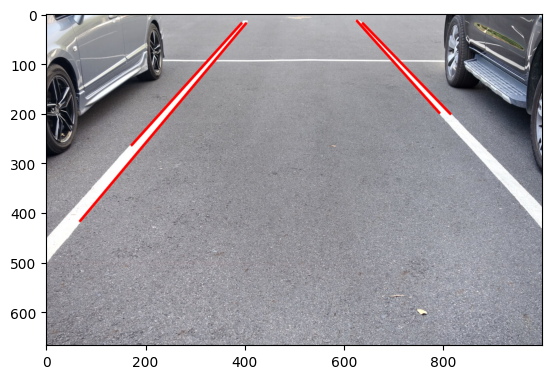

In [155]:
img = cv.imread("./data/test_data/end_point_detection/parking_spot.jpg")
height, width, _ = img.shape
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)
low_hsv, high_hsv = (0, 0, 249), (36, 15, 255)
thresh = cv.inRange(hsv_image, low_hsv, high_hsv)

lines = detect_lines(thresh)
lines = find_longest_lines(lines, top=5)
lines = join_similar_lines(lines, min_dist=0.35)
print(lines.shape)
#print(lines.shape)
#intersections = lines_intersections(lines)
#corners = detect_corners(thresh, blocksize=11, kernel_size=29)

#plt.imshow(thresh, cmap="gray")
for l in lines:
    cv.line(
        img, (round(l[0]*width), round(l[1]*height)), (round(l[2]*width), round(l[3]*height)), (0,0,255), 3, cv.LINE_AA
    )
#img[corners == 1] = [0, 255, 0]
#img = draw_intersections(img, intersections)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))